In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [2]:
# Black-Scholes functions

def bs_call(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_value = S0*norm.cdf(d1) - K*np.exp(-r * T)*norm.cdf(d2)
    return call_value

def bs_put(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2) * T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    put_value = K*np.exp(-r * T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    return put_value

In [3]:
def bs_call_delta(S0, K, T, r, sigma):
    
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    return norm.cdf(d1)

The simulate_garch_paths function generates the stock price paths. The GARCH(1,1) model defines the variance ($h_t$) of the log-returns ($r_t$) at time $t$ using the previous return ($r_{t-1}$) and the previous variance ($h_{t-1}$):$$h_t = \omega + \alpha r_{t-1}^2 + \beta h_{t-1}$$

In [4]:
# GARCH(1,1) path simulator

def simulate_garch_paths(T_days, trials, omega, alpha, beta, S0=250.0, r=0.0):
    eps = np.random.normal(size=(T_days, trials))
    h = np.zeros((T_days, trials))
    ret = np.zeros((T_days, trials))
    
    if alpha + beta < 1.0:
        h0 = omega / (1 - alpha - beta)
    else:
        h0 = omega / 0.01
    
    h[0, :] = h0
    ret[0, :] = np.sqrt(h[0, :]) * eps[0, :]
    
    for t in range(1, T_days):
        h[t, :] = omega + alpha * ret[t-1, :]**2 + beta * h[t-1, :]
        ret[t, :] = np.sqrt(h[t, :]) * eps[t, :]
        
    log_returns = ret + r - 0.5 * h
    logS = np.log(S0) + np.cumsum(log_returns, axis=0)
    S = np.exp(logS)
    
    return S, h, ret

In the next simulation, the Black-Scholes Delta is calculated using the current price ($S_t$), the time remaining ($T_{\text{rem}}$), and the current realized instantaneous GARCH volatility ($\sigma_{\text{ann}, t}$).

In [7]:
# Monte Carlo delta-hedge experiment

def mc_delta_hedge(alpha_list, beta=0.8, omega=1e-6, T_days=252, trials=10000, S0=250, K=240, r=0.0):
    dt = 1/252
    summary = []
    mean_series = {}
    
    for alpha in alpha_list:
        S, h, _ = simulate_garch_paths(T_days, trials, omega, alpha, beta, S0=S0, r=r)
        sigma_ann = np.sqrt(h) * np.sqrt(252)
        
        cash = np.zeros(trials)
        stock_pos = np.zeros(trials)
        pnl_path = np.zeros((T_days, trials))

        for t in range(T_days):
            S_t = S[t, :] 
            T_rem = (T_days - t) * dt 
            sig = sigma_ann[t, :]
            
            opt_val = bs_call(S_t, K, T_rem, r, sig) 
            delta = bs_call_delta(S_t, K, T_rem, r, sig)
            
            new_pos = -delta 
            trade = new_pos - stock_pos
            cash = cash - trade * S_t 
            stock_pos = new_pos 
            
            portfolio_val = opt_val + stock_pos * S_t + cash 
            pnl_path[t, :] = portfolio_val
            
            # Final day adjustment: use intrinsic value and close stock position
            if t == T_days - 1:
                final_opt_val = np.maximum(S_t - K, 0.0)
                trade_close = 0.0 - stock_pos
                cash = cash - trade_close * S_t 
                stock_pos = 0.0
                final_pnl = final_opt_val + cash
                pnl_path[t, :] = final_pnl

        all_final = pnl_path[-1, :] 
        
        mean_final_pnl = all_final.mean()
        std_final_pnl = all_final.std(ddof=1)
        rmse_final_pnl = np.sqrt(np.mean(all_final**2))
        
        all_paths_mean = pnl_path.mean(axis=1)
        mean_series[alpha] = all_paths_mean
        
        summary.append({
            'alpha': alpha,
            'mean_final_pnl': mean_final_pnl,
            'std_final_pnl': std_final_pnl,
            'rmse_final_pnl': rmse_final_pnl
        })
        
    return pd.DataFrame(summary), mean_series

In [8]:
# Parameters

alpha_values = [0.0, 0.02, 0.10, 0.15, 0.2]
beta = 0.80
omega = 1e-6
T_days = 252
trials = 10000 

results_df, mean_series = mc_delta_hedge(alpha_values, beta=beta, omega=omega, T_days=T_days, trials=trials)

print(results_df)

   alpha  mean_final_pnl  std_final_pnl  rmse_final_pnl
0   0.00       10.541158       0.503446       10.553172
1   0.02       10.635099       0.528495       10.648221
2   0.10       11.442851       0.818075       11.472054
3   0.15       12.999284       1.658472       13.104641
4   0.20       22.148481      14.205512       26.312196


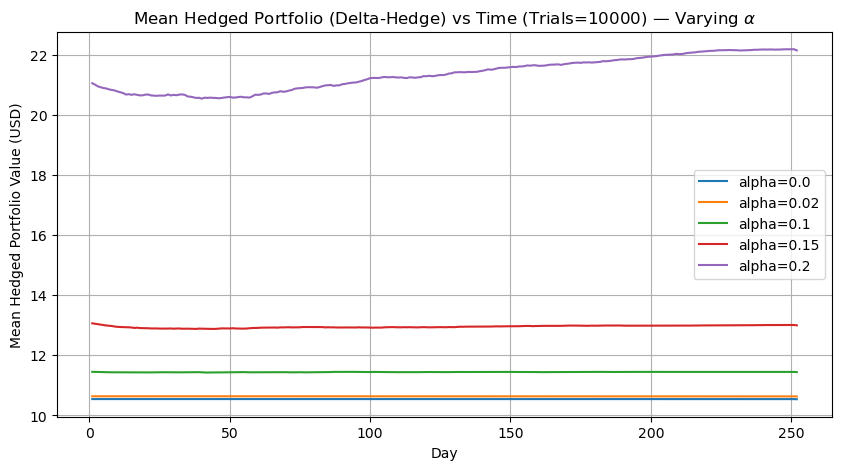

In [9]:
# Plot: mean hedged portfolio path for each alpha

plt.figure(figsize=(10,5))
for a in alpha_values:
    plt.plot(np.arange(1, T_days+1), mean_series[a], label=f'alpha={a}')
plt.xlabel('Day')
plt.ylabel('Mean Hedged Portfolio Value (USD)')
plt.title(f'Mean Hedged Portfolio (Delta-Hedge) vs Time (Trials={trials}) — Varying $\\alpha$')
plt.legend()
plt.grid(True)

plt.savefig("new1.png")
plt.show()

# Interpretation of Results and Plot:

The plot illustrates how the mean value of a delta-hedged portfolio changes over time under a GARCH(1,1) stock price model, with different values of the $\alpha$ parameter.

Higher $\alpha$ makes the stock price process look like fatter tails and higher peaks in returns, i.e. there is a greater chance of both very small and very large price movements.

# Comparing $\alpha=0.0$ (Ignoring) vs. $\alpha > 0$ (Including):

The $\alpha = 0$ gives the lowest and most stable mean portfolio value. This line represents the most accurate hedge value under minimal volatility risk.

When $\alpha > 0$, the mean portfolio value is higher and increasingly volatile. The value ignificant instability as the simple Black-Scholes Delta fails to account for the heightened volatility risk caused by strong volatility clustering.